In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import sys, os
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Módulo de tratamento de outliers

# Classe
class TrataOutlier:

    # Construtor
    def __init__(self, df: pd.DataFrame) -> None:
        self.df = df

    def count_outliers(self, Q1, Q3, IQR, columns):
        cut_off = IQR * 1.5
        temp_df = (self.df[columns] < (Q1 - cut_off)) | (self.df[columns] > (Q3 + cut_off))
        return [len(temp_df[temp_df[col] == True]) for col in temp_df]

    def calc_skew(self, columns=None):
        if columns == None:
            columns = self.df.columns
        return [self.df[col].skew() for col in columns]

    def percentage(self, list):
        return [str(round(((value/150001) * 100), 2)) + '%' for value in list]

    def remove_outliers(self, columns):
        for col in columns:
            Q1, Q3 = self.df[col].quantile(0.25), self.df[col].quantile(0.75)
            IQR = Q3 - Q1
            cut_off = IQR * 1.5
            lower, upper = Q1 - cut_off, Q3 + cut_off
            self.df = self.df.drop(self.df[self.df[col] > upper].index)
            self.df = self.df.drop(self.df[self.df[col] < lower].index)

    def replace_outliers_with_fences(self, columns):
        for col in columns:
            Q1, Q3 = self.df[col].quantile(0.25), self.df[col].quantile(0.75)
            IQR = Q3 - Q1
            cut_off = IQR * 1.5
            lower, upper = Q1 - cut_off, Q3 + cut_off

            self.df[col] = np.where(self.df[col] > upper, upper, self.df[col])
            self.df[col] = np.where(self.df[col] < lower, lower, self.df[col])

    def getOverview(self, columns) -> None:
        min = self.df[columns].min()
        Q1 = self.df[columns].quantile(0.25)
        median = self.df[columns].quantile(0.5)
        Q3 = self.df[columns].quantile(0.75)
        max = self.df[columns].max()
        IQR = Q3 - Q1
        skew = self.calc_skew(columns)
        outliers = self.count_outliers(Q1, Q3, IQR, columns)
        cut_off = IQR * 1.5
        lower, upper = Q1 - cut_off, Q3 + cut_off

        new_columns = ['Nome de Coluna', 'Min', 'Q1', 'Median', 'Q3', 'Max', 'IQR', 'Lower fence', 'Upper fence', 'Skew', 'Num_Outliers', 'Percent_Outliers' ]
        
        data = zip([column for column in self.df[columns]], min, Q1, median, Q3, max, IQR, lower, upper, skew, outliers, self.percentage(outliers))

        new_df = pd.DataFrame(data = data, columns = new_columns)
        
        new_df.set_index('Nome de Coluna', inplace = True)
        \
        return new_df.sort_values('Num_Outliers', ascending = False).transpose()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df= pd.read_csv('/content/drive/MyDrive/Salary.csv')

In [ ]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  salary          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [ ]:
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [ ]:
df.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
salary            0
dtype: int64

In [ ]:
df.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
salary            object
dtype: object

In [ ]:
df_new = df.drop(['fnlwgt','education-num'],axis = 1)

In [ ]:
df_new.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Aplicando label Enconding no salario

In [ ]:
df_tranformacao = df_new

In [ ]:
 le = LabelEncoder()

In [ ]:
df_tranformacao['salary'] = le.fit_transform(df_tranformacao['salary'])

In [ ]:
df_tranformacao

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,Assoc-acdm,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,0
32557,40,Private,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,1
32558,58,Private,HS-grad,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,0
32559,22,Private,HS-grad,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,0


In [ ]:
df_tranformacao['salary']

0        0
1        0
2        0
3        0
4        0
        ..
32556    0
32557    1
32558    0
32559    0
32560    1
Name: salary, Length: 32561, dtype: int64

Verificando Outliers


In [ ]:
#Cria o objeto trata outlier
trata_outilier = TrataOutlier(df_tranformacao)

In [ ]:
#Lista de colunas int64
lista_colunas = df_tranformacao.select_dtypes('int64').columns.tolist()

In [ ]:
lista_colunas

['age', 'capital-gain', 'capital-loss', 'hours-per-week', 'salary']

In [ ]:
trata_outilier.getOverview(lista_colunas)

Nome de Coluna,hours-per-week,salary,capital-gain,capital-loss,age
Min,1,0,0,0,17
Q1,40.0,0.0,0.0,0.0,28.0
Median,40.0,0.0,0.0,0.0,37.0
Q3,45.0,0.0,0.0,0.0,48.0
Max,99,1,99999,4356,90
IQR,5.0,0.0,0.0,0.0,20.0
Lower fence,32.5,0.0,0.0,0.0,-2.0
Upper fence,52.5,0.0,0.0,0.0,78.0
Skew,0.227643,1.21243,11.953848,4.594629,0.558743
Num_Outliers,9008,7841,2712,1519,143


<Axes: >

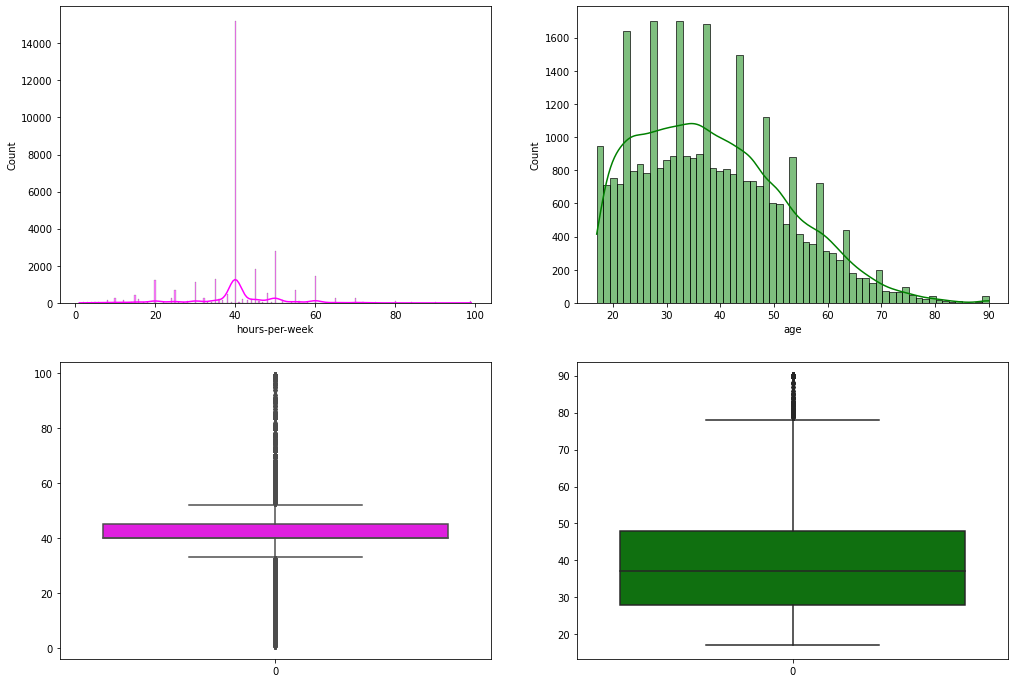

In [ ]:
#Figura 
plt.figure(figsize = (17,12))
plt.subplot(221)
sns.histplot(df_tranformacao['hours-per-week'],kde = True,color = 'magenta')
plt.subplot(222)
sns.histplot(df_tranformacao['age'],kde = True,color = 'green')
plt.subplot(223)
sns.boxplot(df_tranformacao['hours-per-week'], color = 'magenta')
plt.subplot(224)
sns.boxplot(df_tranformacao['age'], color = 'green')

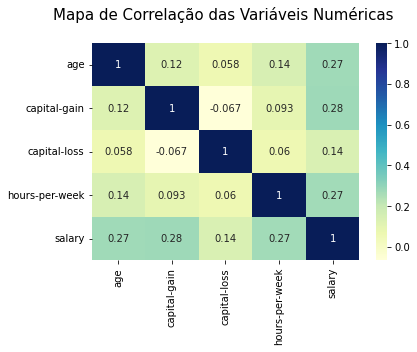

In [ ]:
sns.heatmap(df_tranformacao.corr('spearman'),annot = True,cmap = 'YlGnBu')
plt.title('Mapa de Correlação das Variáveis Numéricas \n',fontsize = 15)
plt.show()

In [ ]:
df_cat = df.drop(['education-num','age','fnlwgt','capital-gain','capital-loss', 'hours-per-week'],axis = 1)

In [ ]:
df_cat.dtypes

workclass         object
education         object
marital-status    object
occupation        object
relationship      object
race              object
sex               object
native-country    object
salary            object
dtype: object

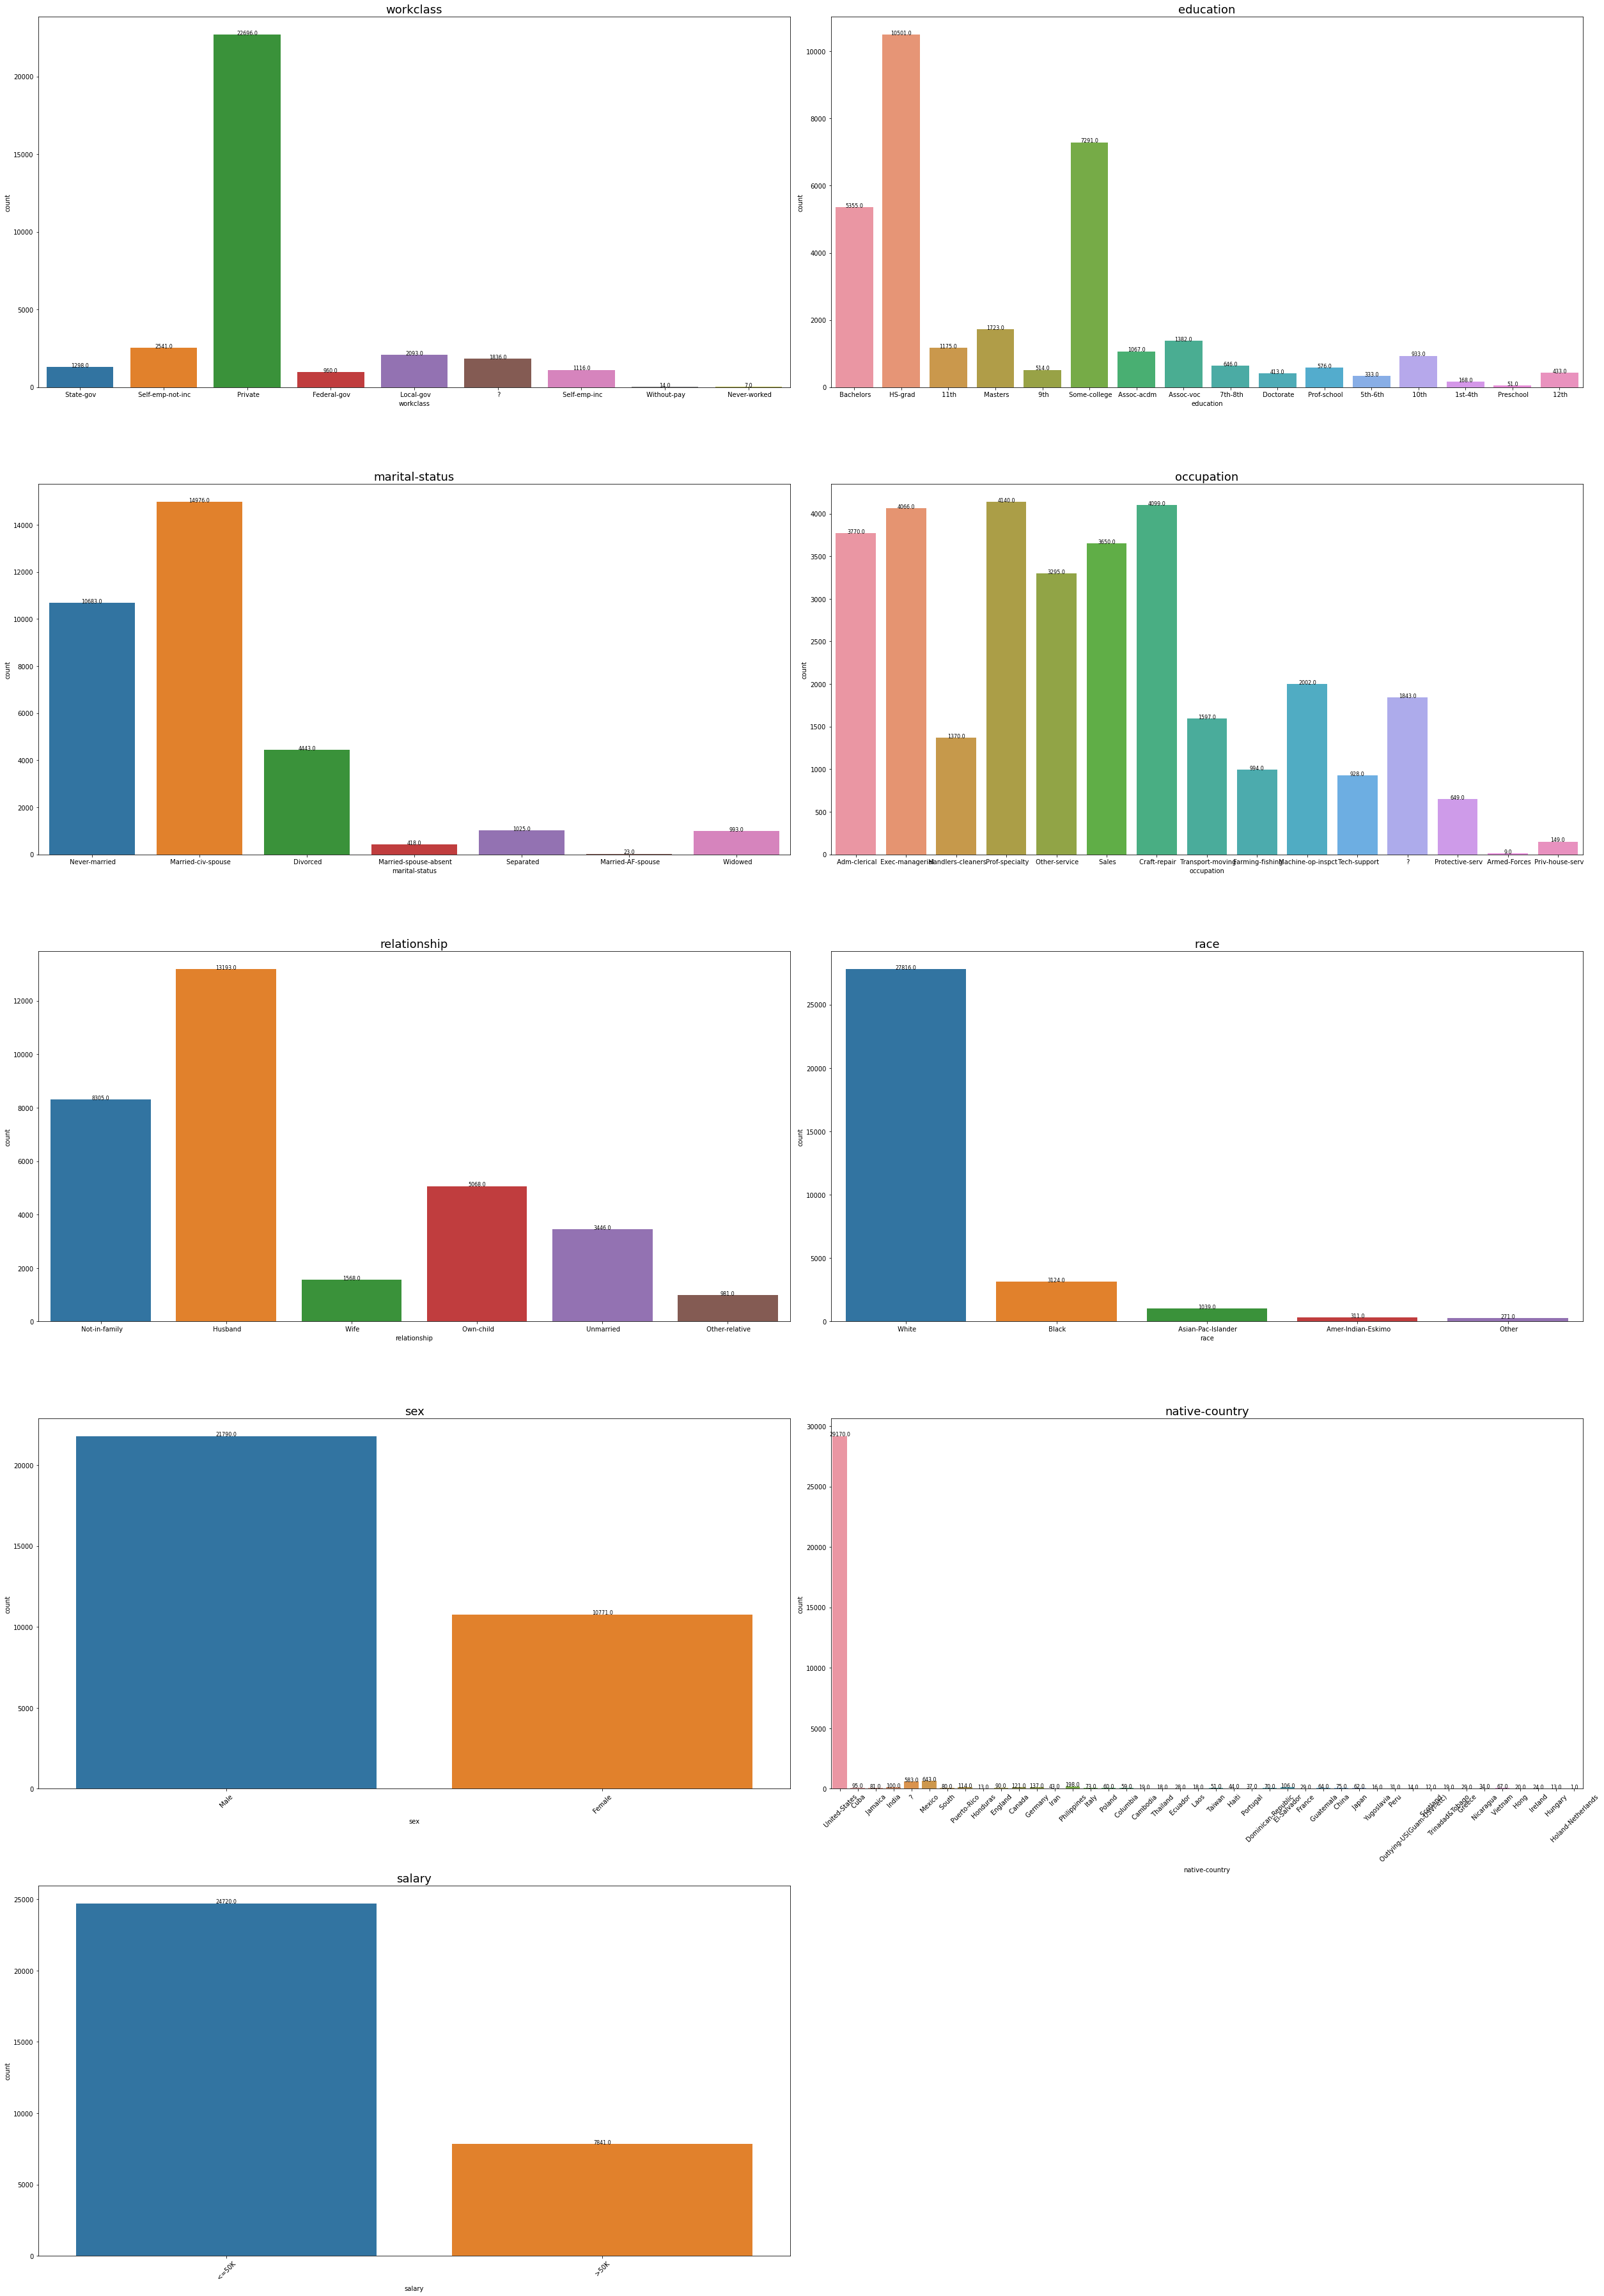

In [ ]:
#Plot 

#tamanho da figura
plt.figure(figsize = (35,50))

#Lista de colunas 
column_list = list(df_cat.columns.values)

#Contador
A = 0

for i in column_list:
  A+= 1 
  plt.subplot(5,2,A)
  ax = sns.countplot(data= df_cat,x=  i)
  plt.title(i,fontsize = 18)
  for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}',(p.get_x()+0.4,p.get_height()),ha = 'center',color = 'black',size = 8)
  if A >=7:
    plt.xticks(rotation = 45)
# Layout
plt.tight_layout(h_pad = 2)

In [ ]:
df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [ ]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11st,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [ ]:
df2['education'].str.strip()

0         Bachelors
1         Bachelors
2           HS-grad
3              11st
4         Bachelors
            ...    
32556    Assoc-acdm
32557       HS-grad
32558       HS-grad
32559       HS-grad
32560       HS-grad
Name: education, Length: 32561, dtype: object

In [ ]:
df2.loc[df['education']=='10th ','education']= '10st'

In [ ]:
df2.loc[df2['education']==' 11th','education']= '11st'

In [ ]:
df2['education'] == ' 11th'

0        False
1        False
2        False
3         True
4        False
         ...  
32556    False
32557    False
32558    False
32559    False
32560    False
Name: education, Length: 32561, dtype: bool

In [ ]:
df2.head(60)

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,11st,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0
5,37,Private,Masters,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,0
6,49,Private,9th,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,0
7,52,Self-emp-not-inc,HS-grad,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,1
8,31,Private,Masters,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,1
9,42,Private,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,1


In [ ]:
print(df2 == True)

0        False
1        False
2        False
3        False
4        False
         ...  
32556    False
32557    False
32558    False
32559    False
32560    False
Name: education, Length: 32561, dtype: bool


<Axes: xlabel='education', ylabel='count'>

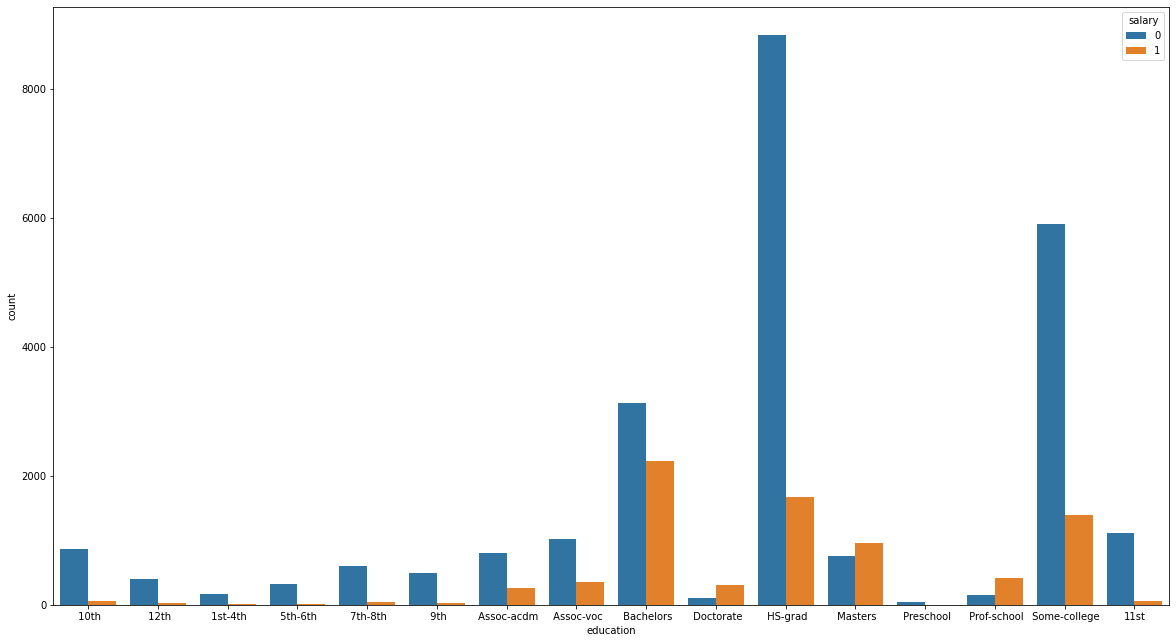

In [ ]:
from numpy.ma.core import sort

#tamanho da figura
plt.figure(figsize = (20,11))
sns.countplot(data = df2.sort_values(by='education'),x='education',hue = 'salary')